In [1]:
import findspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
import warnings 
warnings.filterwarnings('ignore') 
import matplotlib.pyplot as plt
import getpass

findspark.init()
spark = SparkSession.builder.getOrCreate()

In [2]:
spark

In [3]:
driver = 'com.microsoft.sqlserver.jdbc.SQLServerDriver'
username = 'sa'
password = getpass.getpass('password: ')
db = 'Olist'
server = 'DESKTOP-8RSP3AB'
port = '1433'

df = spark.read \
  .format('jdbc') \
  .option("url", f"jdbc:sqlserver://{server}:{port};databaseName={db};trustServerCertificate=true") \
  .option("dbtable", "[dbo].[olist_customers]") \
  .option('driver', driver) \
  .option("user", username) \
  .option("password", password) \
  .load()

In [5]:
df.show(5)

+--------------------+--------------------+------------------------+--------------------+--------------+
|         customer_id|  customer_unique_id|customer_zip_code_prefix|       customer_city|customer_state|
+--------------------+--------------------+------------------------+--------------------+--------------+
|06b8999e2fba1a1fb...|861eff4711a542e4b...|                   14409|              franca|            SP|
|18955e83d337fd6b2...|290c77bc529b7ac93...|                    9790|sao bernardo do c...|            SP|
|4e7b3e00288586ebd...|060e732b5b29e8181...|                    1151|           sao paulo|            SP|
|b2b6027bc5c5109e5...|259dac757896d24d7...|                    8775|     mogi das cruzes|            SP|
|4f2d8ab171c80ec83...|345ecd01c38d18a90...|                   13056|            campinas|            SP|
+--------------------+--------------------+------------------------+--------------------+--------------+
only showing top 5 rows



In [8]:
df.toPandas().info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  object
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: object(5)
memory usage: 34.7 MB


In [9]:
df.printSchema()

root
 |-- customer_id: string (nullable = true)
 |-- customer_unique_id: string (nullable = true)
 |-- customer_zip_code_prefix: string (nullable = true)
 |-- customer_city: string (nullable = true)
 |-- customer_state: string (nullable = true)



### Entendendo sobre a base

A base possui 99.441 linhas e 5 colunas, sendo elas:

- **customer_id**: Identificador único dos clientes relacionado a compras feitas na Olist (não contém valores duplicados)
- **customer_unique_id:**: Identificador único dos clientes (pode conter valores duplicados, ex: um identificador único de um cliente que fez mais de uma compra pode se repetir, mas cada cliente só possui 1 identificador único)
- **customer_zip_code_prefix**: 5 primeiros dígitos do CEP dos clientes
- **customer_city**: Cidade do cliente
- **customer_state**: Estado do cliente

In [10]:
print(f'''
    A base possui um total de {df.toPandas().customer_unique_id.nunique()} clientes espalhados por {df.toPandas().customer_state.nunique()} estados.
''')


    A base possui um total de 96096 clientes espalhados por 27 estados.



Além disso, os clientes se distribuem da seguinte forma entre os estados:

In [25]:
df_states = df\
    .groupBy('customer_state')\
    .agg(
        f.countDistinct(df.customer_unique_id).alias('qtd_clientes')
    )\
    .sort('qtd_clientes', ascending = False)

df_states.show(10)

+--------------+------------+
|customer_state|qtd_clientes|
+--------------+------------+
|            SP|       40302|
|            RJ|       12384|
|            MG|       11259|
|            RS|        5277|
|            PR|        4882|
|            SC|        3534|
|            BA|        3277|
|            DF|        2075|
|            ES|        1964|
|            GO|        1952|
+--------------+------------+
only showing top 10 rows



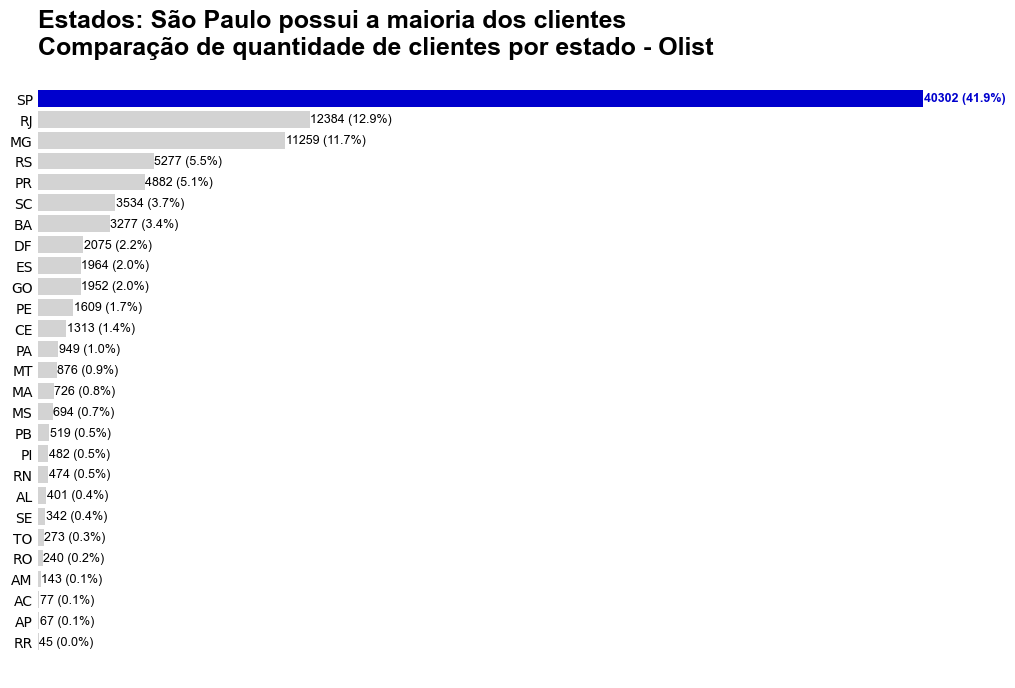

In [27]:
df_graph = df_states.toPandas().sort_values(by = 'qtd_clientes', ascending = True).set_index('customer_state')

# Cores

cores = []

for estado in df_graph.index:
    if estado == 'SP':
        cores.append('mediumblue')
    else:
        cores.append('lightgray')

# Gráfico
fig, ax = plt.subplots(figsize=(12,8))
ax.barh(df_graph.index, df_graph.qtd_clientes, color = cores)
ax.set_frame_on(False)
ax.get_xaxis().set_visible(False)
ax.tick_params(axis='both', which = 'both', length = 0)

# Título
ax.set_title('Estados: São Paulo possui a maioria dos clientes\nComparação de quantidade de clientes por estado - Olist', loc='left', fontsize = 18, fontfamily = 'arial', fontweight = 'bold')


# Anotações

for i, valor in enumerate(df_graph.qtd_clientes):
    if valor == max(df_graph.qtd_clientes):
        plt.text(valor + 25,i,f'{str(valor)} ({(valor/df_graph.qtd_clientes.sum() * 100).round(1)}%)',fontsize=9, ha='left', va='center', fontfamily = 'arial', color = 'mediumblue', fontweight = 'bold')
    else: 
        plt.text(valor + 25,i,f'{str(valor)} ({(valor/df_graph.qtd_clientes.sum() * 100).round(1)}%)',fontsize=9, ha='left', va='center', fontfamily = 'arial')

In [28]:
print(f'''
    O estado com maior quantidade de clientes é: {df_graph.qtd_clientes.idxmax()}
    O estado com menor quantidade de clientes é: {df_graph.qtd_clientes.idxmin()}
    A média de clientes por estado é de: {round(df_graph.qtd_clientes.mean(),2)}
    Com uma desvio padrão de: {round(df_graph.qtd_clientes.std(),2)}
''')


    O estado com maior quantidade de clientes é: SP
    O estado com menor quantidade de clientes é: RR
    A média de clientes por estado é de: 3560.59
    Com uma desvio padrão de: 7983.44



*A média aritmética de clientes não parece ser um bom indicador para inferir sobre a quantidade de clientes por estados devido a alta variação.*

Para entender melhor o cenário e construir soluções que alavanquem o desempenho de vendas em outros estados, precisamos entender se:

  - **Existe alguma relação com a logística de entregas para esse resultado?** 
    - Hipótese: Vendedores não possuem/possuem pouco suporte para entregas em regiões mais afastadas dos grandes centros.
  - **Existe uma relação entre a concentração de clientes e concentração de vendedores nos estados?**
    - Hipótese: Os custos operacionais para entregas em regiões mais afastadas são muito altos, desincentivando os vendedores/Clientes.